# Recherche de motifs dans les génomes: les sites de fixation à l’ADN des facteurs de transcription
Auteurs: Defne Özgüven et Daniel Panariti



## Introduction

La bioinformatique est un domaine de recherche interdisciplinaire extrêmement actif. L'analyse du génome, où se contient information à la base du fonctionnement des êtres vivants, a crée une besoin pour la représetation, gestion et interconnexion de données. L'une des problématiques dans l'analyse du génome comprend la localisation des gènes. Les programmes étant prédictifs, ils génèront des erreurs: gènes qui échappent à la détection (faux négatifs) et gènes qui ne correspondent pas à de vrais gènes (faux-positifs).

Dans le cadre de ce projet, nous allons faire une analyse du génome de la levure *S. cerevisiae*. Plus spécifiquement, une recherche de motifs régulateurs de facteurs de transcription de ce génome. Pour ce faire, il nous faut des données sur des facteurs de transcription de ce génome. Nous travaillerons sur des données déterminés par CHIP-SEQ, qui sont obtenus par l'immunoprecipitation des facteurs de transcription d'intérêt associé à ses motifs de fixation. Notre binôme s'interessera au premiere fichier génomique, "Sequence_by_peaks1.fasta", concentrant donc sur la facteur de transcription Aft1.


Pour faire une telle recherche, il faut implémenter plusieurs algorithmes de recherche de motifs et comparer les résultats afin de faire une analyse complète.

### Fonctions utiles préliminaires



In [ ]:
nuc = ('A', 'C', 'G', 'T')
nuc_low = ('a', 'c', 'g', 't')

In [ ]:
def reverse(s):
    """Return the sequence string in reverse order."""
    letters = list(s)
    letters.reverse()
    return ''.join(letters)

def complement(s):
    """Return the complementary sequence string."""
    basecomplement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'a':'t', 't':'a', 'g':'c', 'c':'g'}
    letters = [basecomplement[base] for base in s]
    return ''.join(letters)

def reversecomplement(s):
    return complement(reverse(s))

def gc(s):
    """Return the percentage of dna composed of G+C."""
    gc = s.count('G') + s.count('C') + s.count('c') + s.count('g')
    return gc * 100.0 / len(s)

In [ ]:
import re
def removeLowComplexe(motifs, m=5):
    """
    Removes motifs with low complexity, i.e., motifs containing repeated mononucleotides or dinucleotides.
    Inputs:
    - motifs: A dictionary or list of motifs.
    - m: Minimum number of repetitions for considering a motif as low complexity.
    Outputs:
    - Cleaned motifs without low complexity.
    """
    nucs = ('A', 'C', 'G', 'T', 'a', 'c', 'g', 't')

    # If a nucleotide is present m times, remove it
    def contains_repeated_mono(motif, m):
        return any(motif.count(nuc) >= m for nuc in nuc_low)

    # If a nucleotide is present m-1 times in a row, remove it
    def contains_repeated_mono_continuous(motif, m):
      return any(run.count(nuc * (m-1)) > 0 for nuc in nucs for run in motif.split())

    # If only two nucleotides are in the motif, remove it
    def contains_only_2_nts(motif, m):
      return len(set(list(motif))) <= 2

    def contains_repeated_di(motif):
      m = (len(motif)-1)//2-1
      all_nuc_di = [nuc_1 + nuc_2 for nuc_1 in nuc_low for nuc_2 in nuc_low if nuc_1 != nuc_2]
      trouve = [nuc_di for nuc_di in all_nuc_di if len(re.findall(re.compile("(?=("+ nuc_di +")"+ nuc_di[0] +")"), motif)) >= m]
      return not(True if len(trouve) == 0 else False)


    if isinstance(motifs, dict):
        motifs_clean = {key: freq for key, freq in motifs.items() if
                        not (contains_repeated_mono(key, m)
                            or contains_repeated_mono_continuous(key,m)
                            or contains_only_2_nts(key, m)
                            or contains_repeated_di(key))
                        }
    elif isinstance(motifs, list):
        motifs_clean = [motif for motif in motifs if
                        not (contains_repeated_mono(motif, m)
                            or contains_repeated_mono_continuous(motif,m)
                            or contains_only_2_nts(motif, m)
                            or contains_repeated_di(motif))]
    else:
        raise TypeError("Error: motifs is neither a list nor a dict")

    return motifs_clean

### Chargement des séquences dans le fichier FASTA

Maintenant, il faut charger les séquences de notre fichier, "Sequence_by_peaks1.fasta". L'ADN est composé de deux brins complémentaires: pour faire une analyse complète, il faut prendre ces deux brins en consideration dans nos analyses.

In [ ]:
def readFasta(fastaFileName):
    """
    Read a fasta file
    entrée fastaFileName: nom du fichier fasta
    sortie séquences: liste contenant toutes les séquences du fichier
    """

    sequence = ""
    sequences_list = []
    prev_header = ""
    header = ""

    for line in open(fastaFileName):
        string = line.strip()
        if string[0] != ">":
            if prev_header != header:
                prev_header = header
            sequence = sequence + string
        else:
            header = string
            if sequence != "":
                sequences_list.append(sequence)
                sequence = ""

    sequences_list.append(sequence)
    return sequences_list

genome = "Sequence_by_Peaks_1.fasta"
seq_by_peaks1 = readFasta(genome)
adn_revC = [reversecomplement(seq) for seq in seq_by_peaks1]
seq_by_peaks1 = seq_by_peaks1 + adn_revC



### Visualisation des données

Afin de visualiser les données pertinents des séquences, on créera une fonction stats_sequences qui calculera, pour chaque séquence, sa longeur et pourcentage de G+C.

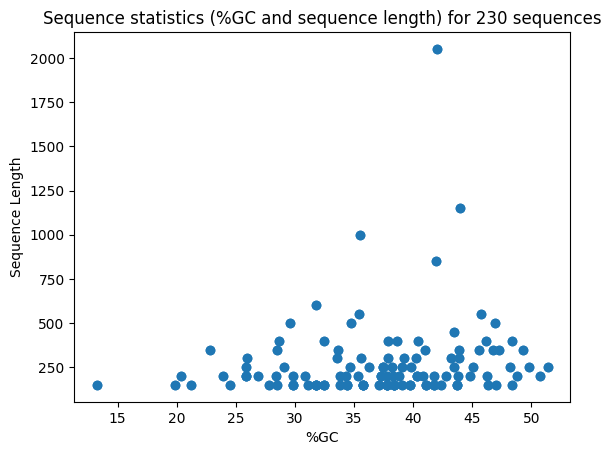

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def stats_sequences(seq_by_peaks, rows):
  stats_seq = {"longeur": 0, "%GC": 0, "%AT": 0}
  i = 0
  print("Sequence:\t Length:\t %GC:\t %AT:\n")
  for seq in seq_by_peaks:
    if i > rows: break
    gc_perc = gc(seq)
    ac_perc = 100 - gc_perc
    print(f"{i}\t\t {len(seq)}\t\t {gc_perc:.2f}\t {ac_perc:.2f}\n")
    i+=1

def scatter_plot_gc_len(seq_by_peaks):
  lengths, gc_freq = [], []

  for seq in seq_by_peaks:
    lengths.append(len(seq))
    gc_freq.append(gc(seq))

  plt.scatter(x = gc_freq, y = lengths)
  plt.title(f"Sequence statistics (%GC and sequence length) for {len(seq_by_peaks)} sequences")
  plt.xlabel("%GC")
  plt.ylabel("Sequence Length")
  plt.show()

scatter_plot_gc_len(seq_by_peaks1)

On observe qu'il existe une séquence de taille extrêment grande (de > 2000 pb), il y a plusieurs raisons possible pour cela: une digestion non-complète ou des problèmes de séquençage. Pour être sûr de travailler avec des séquences pures et sécures, on va éliminer cette séquence.

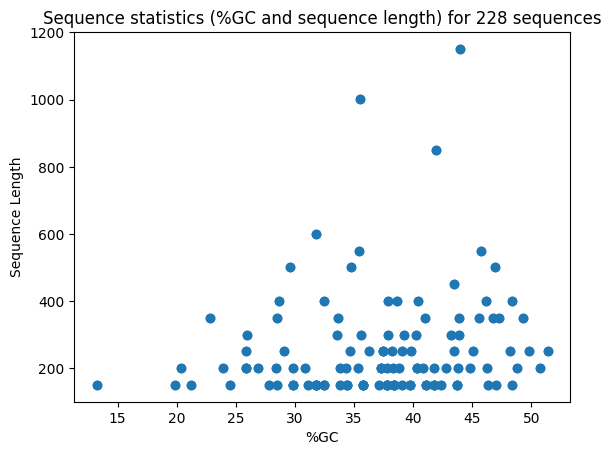

In [ ]:
seq_by_peaks1 = [x for x in seq_by_peaks1 if len(x) < 2000]
scatter_plot_gc_len(seq_by_peaks1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def plot_rectangular_grids(sequences, grid_length=50):
  """Fonction qui permet de visualiser les sequences par rapport
  à leurs compositions en A, T, G, et C

  Args:
      sequences (arr): liste de seqeunces
      grid_length (int, optional): Longeur du rectangle crée. Defaults to 50.
  """
  char_to_value = {'A': 1, 'a':1,
                   'T': 2, 't':2,
                   'C': 3, 'c':3,
                   'G': 4, 'g':4}

  colors = {0: 'white', 1: 'red', 2: 'blue', 3: 'yellow', 4: 'green'}
  cmap = ListedColormap([colors[nucleotide] for nucleotide in colors.keys()])

  fig, axs = plt.subplots(len(sequences), figsize=(10, len(sequences)))
  i = 0
  # Iterate over each subplot
  for seq in sequences:
    seq_list = [char_to_value[s] for s in seq]
    rest = grid_length - len(seq_list) % grid_length
    seq_list += [0] * rest

    # grid_width = int(len(seq) / grid_length + 1)
    # Reshape the sequence into a 2D array
    seq_list = np.array(seq_list).reshape((-1, grid_length))

    # Matplotlib stuff
    axs[i].imshow(seq_list, cmap=cmap, aspect='auto', interpolation='nearest')
    axs[i].set_title(f'Sequence {i+1}')
    axs[i].set_xticks(np.arange(0, grid_length, 10))  # Adjusting ticks on the x-axis
    axs[i].set_yticks([])  # Removing y-axis ticks
    # Scaling
    if len(seq) <= grid_length:
        axs[i].set_aspect('auto', adjustable='box')
    else:
        axs[i].set_aspect('auto', adjustable='box')
    i+=1

  legend_colors = [colors[nucleotide] for nucleotide in colors.keys()]
  legend_labels = ['Empty', 'A', 'T', 'C', 'G']
  legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
  fig.legend(handles=legend_patches, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05))
  plt.tight_layout()
  plt.show()

def plot_motifs(sequences, motifs, grid_length=50):
  nucs = ('A', 'C', 'G', 'T', 'a', 'c', 'g', 't')
  ids = {'motif': 1}
  colors = {0: 'white', 1: 'purple'}
  cmap = ListedColormap([colors[id] for id in colors.keys()])

  fig, axs = plt.subplots(len(sequences), figsize=(10, len(sequences)))
  i = 0
  # Iterate over each subplot
  for seq in sequences:
    # Replace motifs with numerical id
    for motif in motifs:
        seq = seq.replace(motif.upper(), str(ids['motif'])*len(motif))
        seq = seq.replace(motif.lower(), str(ids['motif'])*len(motif))

    seq_list = [0 if s in nucs else int(s) for s in seq]
    rest = grid_length - len(seq_list) % grid_length
    seq_list += [0] * rest
    # Reshape the sequence into a 2D array
    seq_list = np.array(seq_list).reshape((-1, grid_length))

    # Matplotlib stuff
    axs[i].imshow(seq_list, cmap=cmap, aspect='auto', interpolation='nearest')
    axs[i].set_title(f'Sequence {i+1}')
    axs[i].set_xticks(np.arange(0, grid_length, 10))  # Adjusting ticks on the x-axis
    axs[i].set_yticks([])  # Removing y-axis ticks
    # Scaling
    if len(seq) <= grid_length:
        axs[i].set_aspect('auto', adjustable='box')
    else:
        axs[i].set_aspect('auto', adjustable='box')
    i+=1

  legend_colors = [colors[nucleotide] for nucleotide in colors.keys()]
  legend_labels = ['Empty', 'motif', 'start']
  legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
  fig.legend(handles=legend_patches, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05))
  plt.tight_layout()
  plt.show()

Sequence:	 Length:	 %GC:	 %AT:

0		 851		 41.95	 58.05

1		 1151		 43.96	 56.04

2		 501		 34.73	 65.27

3		 251		 29.08	 70.92

4		 301		 35.55	 64.45

5		 251		 43.43	 56.57

None


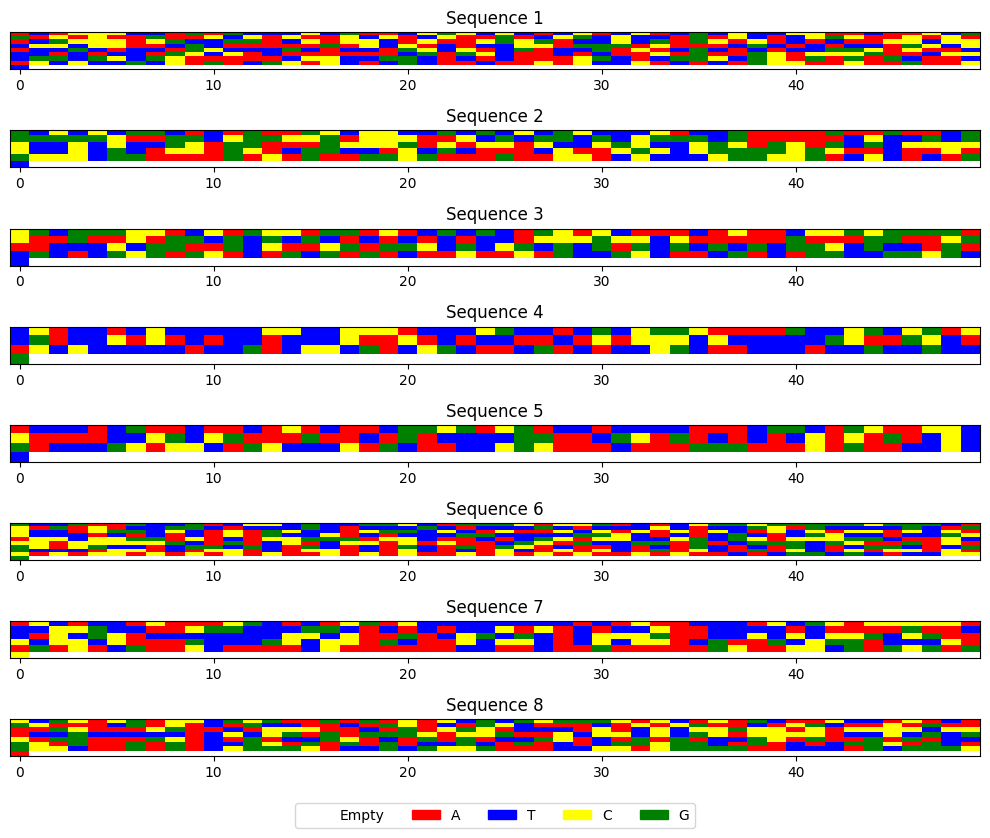

In [ ]:
# Example usage:
print(stats_sequences(seq_by_peaks1, rows = 5))
sequences = seq_by_peaks1[40:48]
plot_rectangular_grids(sequences)

## Table de Hachage (Hash Table)

Avec l'algorithme de table de hachage, on parcourt toutes les séquences pour trouver les motifs de taille k les plus fréquents. Cette algorithme trouve des motifs *invariables* dans les séquences régulatrices.

La compléxité de cette algorithme est (n-k+1).k = O(n.k - k^2 -k) = O(n.k)

On définit
- k = la taille du motif
- n = la taille totale des séquences


### Implémentation de l'algorithme



In [ ]:
def searchMotifs(k:int, sequences:list):
    """
    Cherche les motifs de taille k dans un ensemble de séquences
    entrée k : taille du motif
    entrée séquences : liste de sequences
    sortie motifs: dictionnaire de motifs, clé=motif, valeur = fréquence d'observation
    >>>searchMotifs(3, ['TAAGTAA', 'TATAA', 'CTATC'])
    {'TAA': 3, 'AAG': 1, 'AGT': 1, 'GTA': 1, 'TAT': 2, 'ATA': 1, 'CTA': 1, 'ATC': 1}
    """
    motifs  = {}
    for s in sequences:
        for i in range(len(s)-k+1):
            if s[i:i+k] not in motifs:motifs[s[i:i+k]] = 1
            else:motifs[s[i:i+k]] = motifs[s[i:i+k]] + 1
    return motifs

def getTopMotifs(motifs:dict(), top:int):
    """
    renvoyer les top motifs le plus frequent
    entrée motifs: dictionnaire de motifs, clé=motif, valeur = fréquence d'observation
    entrée top : les top plus frequent
    sortie motifsfreq: dictionnaire contenant les top motifs les plus fréquents, clé=motif, valeur = fréquence d'observation
    >>>getTopMotifs({'TAA': 3, 'AAG': 1, 'AGT': 1, 'GTA': 1, 'TAT': 2, 'ATA': 1, 'CTA': 1, 'ATC': 1}, 2)
    {'TAA': 3, 'TAT': 2}
    """
    mot_max = [(0, "") for i in range(top)]

    for key in motifs.keys():
        for i in range(top):
            if motifs[key] > mot_max[i][0]:
                mot_max.insert(i, (motifs[key], key))
                mot_max.pop()
                break
            else: continue
    motifsfreq  = {v:k for k,v in mot_max}
    return motifsfreq

### Comparaison de la complexité

In [ ]:
k=8
def compare_complexity_motifs(m_floor, m_roof, sequences):
  print("Complexity (num repetitions):\t Number of motifs found: \t Top 3 motifs:")
  for m_i in range(m_floor, m_roof):
    horiz = "-"*40
    motifs = removeLowComplexe(searchMotifs(k, sequences), m = m_i)
    length_m = len(motifs)
    top3_m = getTopMotifs(motifs, top = 3)
    print(f"\t{m_i}\t\t\t\t{length_m}\t\t\t{top3_m if length_m > 0 else 'None'}")

  motifs = searchMotifs(k, sequences)
  print((f"\tinf\t\t\t\t{len(motifs)}\t\t\t{getTopMotifs(motifs, top = 3) if length_m > 0 else 'None'}"))
compare_complexity_motifs(1,10,seq_by_peaks1)


Complexity (num repetitions):	 Number of motifs found: 	 Top 3 motifs:
	1				0			None
	2				0			None
	3				282			{'gcatatgc': 4, 'cgatatcg': 4, 'acactgtg': 4}
	4				12676			{'ggtgcaat': 13, 'attgcacc': 13, 'gtgcaatt': 9}
	5				24451			{'ggtgcaat': 13, 'attgcacc': 13, 'gggtgcaa': 12}
	6				27889			{'tacaaata': 14, 'tatttgta': 14, 'ggtgcaat': 13}
	7				28549			{'tacaaata': 14, 'tatttgta': 14, 'ggtgcaat': 13}
	8				28603			{'tacaaata': 14, 'tatttgta': 14, 'ggtgcaat': 13}
	9				28603			{'tacaaata': 14, 'tatttgta': 14, 'ggtgcaat': 13}
	inf				31450			{'aaaaaaaa': 47, 'tttttttt': 47, 'tatatata': 44}


### Resultats et visualisation

In [ ]:
k=6

print(f'k = {k} ; top = {25} ; num_seqs = {len(seq_by_peaks1)}')
print(len(searchMotifs(k, seq_by_peaks1)))
motifs_hashtable_k6 = removeLowComplexe(searchMotifs(k, seq_by_peaks1), m = 3)
print(len(motifs_hashtable_k6))
top25_motifs_hashtable_k6 = getTopMotifs(motifs_hashtable_k6, 25)
print(top25_motifs_hashtable_k6)
print()


k=7

print(f'k = {k} ; top = {25} ; num_seqs = {len(seq_by_peaks1)}')
print(len(searchMotifs(k, seq_by_peaks1)))
motifs_hashtable_k7 = removeLowComplexe(searchMotifs(k, seq_by_peaks1), m=5)
print(len(motifs_hashtable_k7))
top25_motifs_hashtable_k7 = getTopMotifs(motifs_hashtable_k7, 25)
print(top25_motifs_hashtable_k7)
print()

k=8

print(f'k = {k} ; top = {25} ; num_seqs = {len(seq_by_peaks1)}')
print(len(searchMotifs(k, seq_by_peaks1)))
motifs_hashtable_k8 = removeLowComplexe(searchMotifs(k, seq_by_peaks1), m=5)
print(len(motifs_hashtable_k8))
top25_motifs_hashtable_k8 = getTopMotifs(motifs_hashtable_k8, 25)
print(top25_motifs_hashtable_k8)
print()

k = 6 ; top = 25 ; num_seqs = 228
4067
192
{'actgca': 28, 'tgcagt': 28, 'actact': 24, 'agtagt': 24, 'tgctgc': 23, 'gcagca': 23, 'tgcagc': 22, 'gctgca': 22, 'ctgcag': 20, 'tacgta': 20, 'atgcat': 20, 'tagtag': 19, 'cagcat': 19, 'ctacta': 19, 'tactgc': 19, 'gcagta': 19, 'gtagta': 19, 'atgctg': 19, 'tactac': 19, 'tcatga': 18, 'agtact': 18, 'tcatca': 18, 'tgatga': 18, 'atcatg': 17, 'cagtag': 17}

k = 7 ; top = 25 ; num_seqs = 228
13978
12168
{'gggtgca': 37, 'tgcaccc': 37, 'ggtgcaa': 21, 'tatttca': 21, 'ttgcacc': 21, 'tgaaata': 21, 'agttgta': 20, 'gcaccca': 20, 'atttgaa': 20, 'tacaact': 20, 'ttcaaat': 20, 'tgggtgc': 20, 'tttcaaa': 19, 'ttcatat': 19, 'atatgaa': 19, 'tacaaat': 19, 'atttgta': 19, 'gaaattt': 19, 'aaatttc': 19, 'tttgaaa': 19, 'gtgcaat': 18, 'attgcac': 18, 'aggtgca': 18, 'caaatat': 18, 'atatttg': 18}

k = 8 ; top = 25 ; num_seqs = 228
31450
24451
{'ggtgcaat': 13, 'attgcacc': 13, 'gggtgcaa': 12, 'ttgcaccc': 12, 'tgcaccca': 11, 'tgggtgca': 11, 'tgcacccg': 10, 'tgaaatat': 10, 'cgggtg

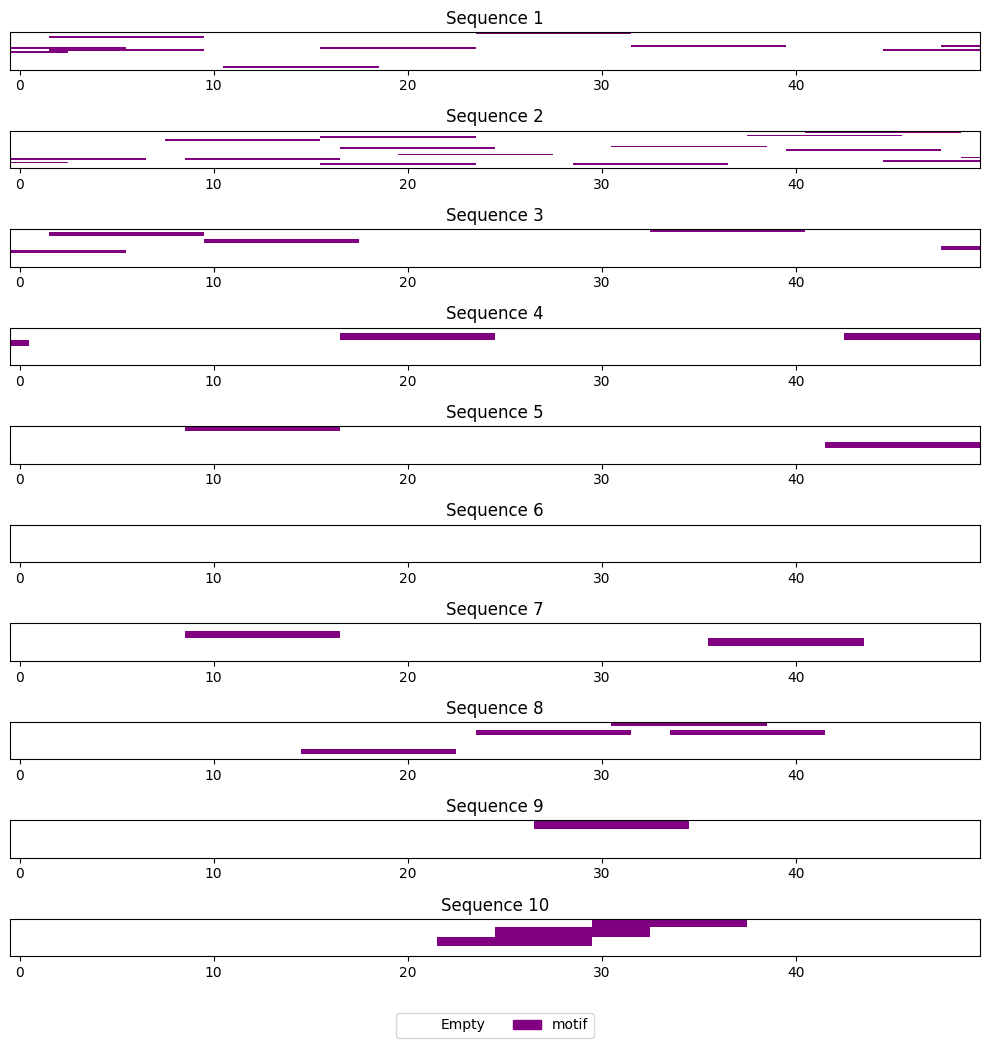

In [ ]:
# Visualisation du top 10 motifs dans les 10 premiers sequences
motifs = list(getTopMotifs(removeLowComplexe(searchMotifs(k, seq_by_peaks1), m = 4), 100).keys())
sequences = seq_by_peaks1[:10]
plot_motifs(sequences, motifs)

## Median String Search


L'algorithme Median String Search permet de comparer tous les motifs possibles de longueur k pour déterminer ceux ayant une somme de Distance de Hamming plus basse. Il ne peut trouver que des motifs invariables dans les séquences régulatrices.
La complexité de cet algorithme est de ~ O(4^k) avec 4 le nombre de nucléotides possibles pour une position donnée et k la taille du motif. Lorsque k augmente, la complexité augmente.

### Implémentation de l'algorithme

In [ ]:
def hamdist(str1:str, str2:str):
	"""
	Calcul la distance de hamming entre deux chaînes de caractères
	entrée str1: chaîne de caractères
	entrée str2: chaîne de caractères
	sortie distance: distance de hamming
	"""
	diffs = len([(x,y) for x,y in zip(str1, str2) if x != y])
	return diffs

def totalDistance(motif:str, sequences, k):
	"""
	Calcul la totalDistance
	entrée motif: sequence consensus
	entrée sequences: chaîne de caractères
	entrée k: taille du motif
	entrée sequences: matrice de dimension txn contenant les séquences
	sortie totalDistance: somme de distance de hamming minimal
	"""
	td = 0
	for seq in sequences:
		distances = [hamdist(motif, seq[i: i + k]) for i in range(len(seq) - k)]
		td += min(distances)

	return td

def MedianStringSearch(allkmers, sequences, k):
	"""
	Implement l'algorithme MedianStringSearch
	entrée allkmers: liste de K-mers valides
	entrée sequences: matrice de dimension txn contenant les séquences
	entrée k: taille du motif
	sortie bestMotif: le motif que minimise les distances
	sortie bestDistance: la distance minimal
	sortie motifDist: un dictionnaire contenant les motifs et leurs distances
	"""
	bestDistance = 1000
	motifDist = {}
	bestMotif = ""
	#for kmer in removeLowComplexe(allkmers, k):
	for kmer in allkmers:
		totalDist = totalDistance(kmer, sequences, k)
		motifDist[kmer] = totalDist
		if totalDist < bestDistance:
			bestDistance = totalDist
			bestMotif = kmer

	return bestMotif, bestDistance, motifDist

In [ ]:
totalDist = totalDistance('tgcaccc', seq_by_peaks1, k=7)
print(totalDist)

385


In [ ]:
from itertools import product
#Genere tous les K-mers de taille K ayant de AAA... à TTT...
k=6; allkmers_k6 = product(nuc_low, repeat=k)
kmers = [''.join(seq) for seq in list(allkmers_k6)]
kmersValid_k6 = removeLowComplexe(kmers, m = 3)

k=7; allkmers_k6 = product(nuc_low, repeat=k)
kmers = [''.join(seq) for seq in list(allkmers_k6)]
kmersValid_k7 = removeLowComplexe(kmers, m = 5)

k=8; allkmers_k6 = product(nuc_low, repeat=k)
kmers = [''.join(seq) for seq in list(allkmers_k6)]
kmersValid_k8 = removeLowComplexe(kmers, m=4)

print(f'For a motif size of 6, there are {len(kmersValid_k6)} motifs')
print(f'For a motif size of 7, there are {len(kmersValid_k7)} motifs')
print(f'For a motif size of 8, there are {len(kmersValid_k8)} motifs')

For a motif size of 6, there are 192 motifs
For a motif size of 7, there are 14280 motifs
For a motif size of 8, there are 30600 motifs


### Resultats et visualisation

In [ ]:
bestMotif_k6, bestDistance_k6, motifDist_k6 = MedianStringSearch(kmersValid_k6, seq_by_peaks1, k)
print (bestMotif_k6, bestDistance_k6)

bestMotif_k7, bestDistance_k7, motifDist_k7 = MedianStringSearch(kmersValid_k7, seq_by_peaks1, k)
print (bestMotif_k7, bestDistance_k7)

bestMotif_k8, bestDistance_k8, motifDist_k8 = MedianStringSearch(kmersValid_k8, seq_by_peaks1, k)
print (bestMotif_k8, bestDistance_k8)

tgatca 276
atatttg 306
atattgca 442


In [ ]:
def getBottomMotifs(motifs:dict(), top:int):
    """
    renvoyer les top motifs avec la distance la plus basse
    entrée motifs: dictionnaire de motifs, clé=motif, valeur = fréquence d'observation
    entrée top : les top plus frequent
    sortie motifsfreq: dictionnaire contenant les top motifs, clé=motif, valeur = distance associé
    """
    mot_max = [(10e9, "") for i in range(top)]

    for key in motifs.keys():
        for i in range(top):
            if motifs[key] < mot_max[i][0]:
                mot_max.insert(i, (motifs[key], key))
                mot_max.pop()
                break
            else: continue
    motifsfreq  = {v:k for k,v in mot_max}
    return motifsfreq

top_25_mss_k6 = (getBottomMotifs(motifDist_k6, 25))
top_25_mss_k7 = (getBottomMotifs(motifDist_k7, 25))
top_25_mss_k8 = (getBottomMotifs(motifDist_k8, 25))

print(top_25_mss_k6)
print(top_25_mss_k7)
print(top_25_mss_k8)

{'tgatca': 276, 'atgcat': 281, 'agtact': 282, 'catgat': 282, 'actgca': 283, 'tgcagt': 283, 'atcatg': 284, 'agtcat': 285, 'atgact': 286, 'tagcat': 288, 'atgcta': 290, 'tactac': 290, 'tactgc': 290, 'gtagta': 291, 'tagcta': 291, 'tcatca': 291, 'tgatga': 291, 'tcagta': 292, 'actgct': 293, 'agcagt': 293, 'cagcta': 293, 'ctacta': 293, 'gcagta': 293, 'tactga': 293, 'actact': 294}
{'atatttg': 306, 'caaatat': 307, 'atatttc': 308, 'gaaatat': 308, 'ttcaaat': 312, 'atttgaa': 314, 'ttgaaat': 314, 'tatttca': 315, 'tgaaata': 316, 'atttcaa': 317, 'aatatct': 318, 'agaaatt': 318, 'aatttct': 319, 'agatatt': 319, 'aattgta': 320, 'tacaatt': 320, 'tttcaaa': 320, 'tttgaaa': 320, 'aatatgt': 322, 'acatatt': 322, 'tgtaaat': 322, 'aaatatg': 323, 'aatttca': 323, 'atatgta': 323, 'atttaca': 323}
{'atattgca': 442, 'tgcaatat': 442, 'tcttacaa': 443, 'ttgtaaga': 443, 'tattgcaa': 444, 'ttgcaata': 444, 'agatattg': 445, 'atatgtca': 445, 'caatatct': 445, 'tgacatat': 445, 'ttgtacaa': 445, 'aattgcat': 446, 'atgcaatt': 446, '

## Greedy Profile Motif Search


Greedy Profile Motif Search (GPMS)est un algorithme stochastique, c'est-à-dire que les résultats de chaque exécution serait différent. Dans GPMS, des positions sont choisis aléatoirement dans la sequence pour créer un profile des nucleotides. À partir de ce profil les kmers le plus probables sont trouvés. L'algorithme continue jusqu'à stabilité dans le score du motif trouvés.

### Implémentation de l'algorithme

In [ ]:
import random
import numpy as np

t=len(seq_by_peaks1) #nb de sequences

def generateRandomS(sequences, k):
	"""
	Génère un vecteur de position aléatoires
	entrée sequences: matrice de dimension txn contenant les sequences
	entrée k: taille du motif
	sortie s: vecteur de position aléatoires, une position par séquence
  REMARQUE les positions doivent être inférieur à n-k, ou n est la taille de sequence
	"""
	s = []
	for seq in sequences:
		seq = [i for i in range(len(seq) - k)]
		index = random.choice(seq)
		s.append(index)
	return s

def extractSeqs(s, seqs, k):
    """
    Extraire les motifs des séquences à l'aide de positions s
    entrée s: vecteur contenant les positions de départs
    entrée seqs: matrice de dimension txn contenant les séquences
    entrée k: taille du motif
    sortie motifs: liste de motifs de taille k extrait des séquences
    """
    motifs = []
    for seq, pos in zip(seqs, s):
        motifs.append(seq[pos: pos+k])
    return motifs

#Construire un profile = matrice de fréquence
def profile(motifs, k, nuc):
    """
    Construire une matrice de fréquence de dimension k x |nuc|
    entrée motifs: liste de motifs
    entrée k: taille du motif
    entrée nuc: alphabet
    sortie MF: matrice de fréquence
    """
    q = len(nuc)
    PWM = np.zeros((q, k))

    for i in range(k):
        for mot in motifs:
            if mot[i] == "A" or mot[i] == "a": PWM[0][i] += 1
            if mot[i] == "C" or mot[i] == "c": PWM[1][i] += 1
            if mot[i] == "G" or mot[i] == "g": PWM[2][i] += 1
            if mot[i] == "T" or mot[i] == "t": PWM[3][i] += 1

    return PWM

def generatePWM(MF):
  """
  Transforme la matrice de fréquence en PWM
  entrée MF: matrice de fréquence
  sortie PWM: matrice de probabilité (poids positions)
  """
  return MF * (1/t)

def probability(PWM, motif):
    """
    Calcul la probalité d'un motif selon PWM
    entrée PWM: matrice de probabilité (poids positions)
    entrée motif: motif
    sortie prob: probalité Prob(motif|PWM)
    """
    prob = 1
    for i in range(len(motif)):
        if motif[i] == "A" or motif[i] == "a": prob *= PWM[0][i]
        if motif[i] == "C" or motif[i] == "c": prob *= PWM[1][i]
        if motif[i] == "G" or motif[i] == "g": prob *= PWM[2][i]
        if motif[i] == "T" or motif[i] == "t": prob *= PWM[3][i]
    return prob

def pMostProbkmer(PWM, k, sequence):
    """
    calcul la position du k-mer le plus probable dans la séquence
    entrée PWM: matrice de probabilité (poids positions)
    entrée k: taille du motif
    entrée sequence: séquence nucleotidique
    sortie s: la position la plus probable
    """
    maxProb = 0
    s = 0 # position du k-mer le plus probable dans la sequence
    for i in range(len(sequence) - k):
        proba = probability(PWM, sequence[i:i+k])
        if proba > maxProb:
            maxProb = proba
            s = i
    return s

def getNewS(PWM, k, sequences):
    """
    Trouve les nouvelles positions des k-mer le plus probables
    entrée PWM: matrice de probabilité (poids positions)
    entrée k: taille du motif
    entrée sequence: séquence nucleotidique
    sortie s: vecteur avec les positions les plus problables
    """
    s = []
    for seq in sequences:
        s.append(pMostProbkmer(PWM, k, seq))

    return s

def changeProfile(P1, P2):
    """
    Compare deux matrice
    entrée P1: matrice de fréquence
    entrée P2: matrice de fréquence
    sortie: True si les matrices sont différents, False au contraire
    """

    return np.allclose(P1, P2)

def getScore(MF, k):
    """
    Renvoie le score de MF, la somme des max de chaque colonne
    entrée MF: matrice de fréquence
    entrée k: taille du motif
    sortie sc: score
    """
    sc = 0
    for col in MF.T:
        sc += np.max(col)
    return sc

def GreedyProfileMotifSearch(sequences, k):
    """
    Implémente l'algorithme GreedyProfileMotifSearch
	  entrée sequences: matrice de dimension txn contenant les séquences
	  entrée k : taille du motif
    sortie s : vecteur de positions de départ ayant le meilleur motif
    sortie bestScore : le score associé à s
    """
    m = 5 if k > 6 else 3 # For removeLowComplexe

    s = generateRandomS(sequences,k)
    bestScore = 0
    motifs = removeLowComplexe(extractSeqs(s, sequences, k), m)
    MF = profile(motifs, k, nuc_low)
    MF = profile(motifs, k, nuc_low)
    MF = np.where(MF==0,1,0)+MF
    x = getScore(MF, k)

    while x > bestScore:
        bestScore = getScore(MF, k)
        for i in range(len(sequences)):
            s[i] = pMostProbkmer(generatePWM(MF), k, sequences[i])
        motifs = removeLowComplexe(extractSeqs(s, sequences, k), m)
        MF = profile(motifs, k, nuc_low)
        MF = np.where(MF==0,1,0)+MF
        x = getScore(MF, k)

    return s, getScore(MF, k)

from statistics import mode
def GreedyProfileMotifSearchIte(sequences, k, It):
    """
    Implémente l'algorithme GreedyProfileMotifSearch iteratif
	  entrée séquences: matrice de dimension txn contenant les séquences
	  entrée k: taille du motif
    entrée It: nombre d'iterations
    sortie positions: dictionnaire clé=score, valeur= vecteur s
    sortie consensus: dictionnaire clé=score, valeur= sequence consensus du motif
    """
    pos = {}
    consensus = {}
    Scores = [j for j in range(It)]
    m = 3 if k < 7 else 5

    for i in range(It):
        s, score = GreedyProfileMotifSearch(sequences, k)
        # print("seqs=", extractSeqs(s, sequences, k))
        Scores[i] = score
        pos[score] = s
        consensus[score] = mode(removeLowComplexe(extractSeqs(s, sequences, k), m))

    J = Scores.index(max(Scores))

    return pos, consensus

def printTopFMotifsScore(consensus, top):
    motifsSort = sorted(consensus.keys())
    print(f'top = {top}')
    motifsSort.reverse()
    for i in range(top):
      print (f'{consensus[motifsSort[i]]} : {motifsSort[i]} ')



### Résultats et visualisation

In [ ]:
s, greedy_consensus_k6 = GreedyProfileMotifSearchIte(seq_by_peaks1, k=6, It = 50)
s, greedy_consensus_k7 = GreedyProfileMotifSearchIte(seq_by_peaks1, k=7, It = 50)
s, greedy_consensus_k8 = GreedyProfileMotifSearchIte(seq_by_peaks1, k=8, It = 50)

# Results
print(f'For k=6, there are {len(greedy_consensus_k6)} sequences.'); printTopFMotifsScore(greedy_consensus_k6, 25);
print(f'For k=7, there are {len(greedy_consensus_k7)} sequences.'); printTopFMotifsScore(greedy_consensus_k7, 25);
print(f'For k=8, there are {len(greedy_consensus_k8)} sequences.'); printTopFMotifsScore(greedy_consensus_k8, 25);

greedy_consensus_motifs_k6  = list(greedy_consensus_k6.values())
greedy_consensus_motifs_k7  = list(greedy_consensus_k7.values())
greedy_consensus_motifs_k8  = list(greedy_consensus_k8.values())

greedy_top25_k6 = sorted(greedy_consensus_motifs_k6.keys())[0:25]
greedy_top25_k7 = sorted(greedy_consensus_motifs_k7.keys())[0:25]
greedy_top25_k8 = sorted(greedy_consensus_motifs_k8.keys())[0:25]

For k=6, there are 45 sequences.
top = 25
gcagca : 566.0 
tgctgc : 549.0 
tgctgc : 543.0 
agcagc : 542.0 
gcagca : 541.0 
gcagca : 539.0 
gcagca : 537.0 
tgctgc : 536.0 
gctgct : 524.0 
gcagca : 520.0 
agcagc : 506.0 
cagcat : 502.0 
gctgct : 497.0 
tcatca : 486.0 
atcatg : 484.0 
tgatga : 479.0 
atgatc : 477.0 
tcatca : 476.0 
cagcat : 475.0 
atgatc : 474.0 
agtagt : 466.0 
tgctgc : 460.0 
atcatg : 459.0 
gcagca : 458.0 
agtagt : 455.0 
For k=7, there are 48 sequences.
top = 25
tttgaaa : 1148.0 
tttgaaa : 1135.0 
tttgaaa : 1064.0 
atttcaa : 1015.0 
tcaaatt : 996.0 
tttcaaa : 985.0 
tttagaa : 984.0 
taatgat : 950.0 
atttcaa : 901.0 
ttgaaat : 894.0 
attcaat : 890.0 
ttatcat : 850.0 
atatgaa : 817.0 
tgaataa : 754.0 
tattgta : 375.0 
atgataa : 364.0 
tagttta : 325.0 
tcaataa : 318.0 
caattaa : 316.0 
attctta : 303.0 
gaattta : 296.0 
atttgaa : 287.0 
aaatagt : 279.0 
tacaatg : 276.0 
tacaaat : 255.0 
For k=8, there are 48 sequences.
top = 25
ttcaatat : 1074.0 
ttgaagtt : 1007.0 
ttgaaat

In [ ]:
print('gggtgca' in list(greedy_consensus_k7.values()))

for motif in list(greedy_consensus_k7.values()):
  if hamdist(motif, 'gggtgca') < 5:
    print(motif)

False
atttgaa
tagttta
atatgaa
tgttaaa
tattgta
gaattta


## Random Projection

Random Projection est un autre algorithme stochastique qui essaie de modéliser les variations / mutations qui existents dans les séquences. En choissisant au hasard un sous-ensemble de positions d'un motif pour créer une projection, on recherche cette position espérant que les positions choisis n'ont pas été affectés. On produit ainsi un bucket des motifs. En relançant l'algorithme plusieurs fois, on peut evaluer les buckets et prendre le meilleur.

### Implémentation de l'algorithme

In [ ]:
import random as rand

def getRandomFixePositions(p, k):
    """
    Genere une projection de p vers k
    entrée p: nombre de positions choisi pour la projection
    entrée k: nombre de positions du motif original
    sortie projection: liste de positions choisi aléatoirement
    """
    #(hypothèse: p <= k )
    orig = [i for i in range(k)]
    projection = []

    for i in range(p):
        curr_i = rand.choice(orig)
        projection.append(curr_i)
        orig.remove(curr_i)
    count = 0

    return projection

def generateKey(projection, motif):
    """
    extrait les caractères du motif et génère la cle de la projection
    entrée projection : liste de positions qui represent la projection
    entrée motif : motif de taille k
    sortie cle : cle de la projection
    """
    cle = ""
    for i in projection:
        cle += (motif[i])

    return cle

def randomProjection(k, p, sequences):
    """
    Implémente l'algorithme randomProjection
    entrée k : taille du motif
    entrée p : nombre de positions de la projection
    entrée sequences : matrice de dimension txn contenant les séquences
    sortie motifs : dictionaire, cle = projection, :valeur= frequence
    sortie motifsSeq:  dictionaire, cle = projection, valeur= original motif
    """
    motifs  = {}; motifsSeq  = {}
    m = 3 if k < 7 else 5

    initial_proj = getRandomFixePositions(p, k)
    initial_proj.sort()
    for seq in sequences:
        for i in range(len(seq) - k):
            motif = seq[i:i+k]
            projection = generateKey(initial_proj, motif)

            motifs[projection] = motifs.get(projection, 0) + 1
            motifsSeq[projection] = motifsSeq.get(projection, []) + [motif]

    motifsSeq = {k:removeLowComplexe(v, m) for k,v in motifsSeq.items()}
    motifsSeq = {k:v for k,v in motifsSeq.items() if len(v) > 0}
    motifs = {k:v for k,v in motifs.items() if k in list(motifsSeq.keys())}
    return motifs, motifsSeq


In [ ]:
import math
def profile(motifs, k, nuc):
    """
    Construire une matrice de fréquence de dimension k x |nuc|
    entrée motifs: liste de motifs
    entrée k: taille du motif
    entrée nuc: alphabet
    sortie MF: matrice de fréquence
    """
    q = len(nuc)
    PWM = np.zeros((q, k))

    for i in range(k):
        for mot in motifs:
            if mot[i] == "A" or mot[i] == "a": PWM[0][i] += 1
            if mot[i] == "C" or mot[i] == "c": PWM[1][i] += 1
            if mot[i] == "G" or mot[i] == "g": PWM[2][i] += 1
            if mot[i] == "T" or mot[i] == "t": PWM[3][i] += 1

    return PWM

def getScore(MF, k):
    """
    Renvoie le score de MF, la somme des max de chaque colonne
    entrée MF: matrice de fréquence
    entrée k: taille du motif
    sortie sc: score
    """
    sc = 0
    for col in MF.T:
        sc += np.max(col)

    return sc

def determine_highest_freq(motifs, motifsSeq):
    best_score = 0
    projs_to_search = []
    seqs = []

    for proj in motifs:
        if motifs[proj] > best_score:
            best_score = motifs[proj]
            projs_to_search = [proj]
            continue
        if motifs[proj] == best_score:
            projs_to_search.append(proj)
    for proj in projs_to_search:
        seqs.append(motifsSeq[proj])

    seqs = [x for xs in seqs for x in xs]
    return seqs


def randomProjIt(sequences, k, v, nuc, It):
    """
    Implémente l'algorithme randomProjection version iterative
    entrée sequences : matrice de dimension txn contenant les séquences
    entrée k : nombre de positions du motif
    entrée v : nombre de positions de la projection
    entrée nuc : alphabet
    entrée It: nombre d'iterations
    sortie score : meilleur score
    sortie motifs :  liste de motifs associés au meilleur score
    """
    motifsres = []; score = 0
    p = math.ceil(0.7*k)

    for i in range(It):
        motifs, motifsSeq = randomProjection(k, p, sequences)
        curr_motifs = determine_highest_freq(motifs, motifsSeq)
        curr_motifs = removeLowComplexe(curr_motifs, k)

        curr_score = getScore(profile(curr_motifs, k, nuc), k)
        if curr_score > score:
            score = curr_score
            motifsres = curr_motifs

    return score, list(set(motifsres))

def printTopFMotifsFreq(motifs, m, rev=False):
    motifsRet = {}
    motifsSort = sorted(motifs, reverse=True, key=motifs.get)
    print(motifsSort)
    i = 0
    while (i < m):
        motifPrint = motifsSort[i]
        if rev:
            motifPrint = reversecomplement(motifsSort[i])
        print (i, motifPrint, "-", motifs[motifsSort[i]])
        i = i + 1

### Résultats et visualisation

In [ ]:
p=5
score, seqsMotif_k6 = randomProjIt(seq_by_peaks1, 6, p, nuc, 100)
print(len(seqsMotif_k6))
print(score, seqsMotif_k6)

p=5
score, seqsMotif_k7 = randomProjIt(seq_by_peaks1, 7, p, nuc, 100)
print(len(seqsMotif_k7))
print(score, seqsMotif_k7)

p=6
score, seqsMotif_k8 = randomProjIt(seq_by_peaks1, 8, p, nuc, 100)
print(len(seqsMotif_k8))
print(score, seqsMotif_k8)

4
313.0 ['catcat', 'gatcat', 'catgat', 'gatgat']
10
566.0 ['atattga', 'atatgta', 'atatcga', 'atatcta', 'atatgaa', 'atatcca', 'atatgga', 'atatgca', 'atattca', 'atatcaa']
8
224.0 ['aagatatt', 'gagatatt', 'caaatatt', 'tagatatt', 'aacatatt', 'cacatatt', 'gacatatt', 'gaaatatt']


REMARQUE: Dans l'implémentation de notre algorithme, nous avons décidé d'éliminer les motifs peu complexes du bucket. On note que l'algorithme a la tendance à produire des buckets avec pas mal de motifs simples.

## Suffix Tree


L'algorithme Suffix Tree consiste à construire un arbre des suffixes à partir de l'ADN. Pour rechercher un motif on peut simplement parcourir l'arbre. On vérifie pour chaque motif s'il peut être généré à partir de la racine. Si on veut chercher un motif variable, on peut permettre des variations en coupant le motif.

### Implémentation de l'algorithme


In [ ]:
!pip install suffix_trees

In [ ]:
from suffix_trees import STree

def construct_tree(sequences):
    """
    construire un abre de suffixe
    entrée1 : matrice de dimension txn avec les sequences
    sortie1 : arbre de suffixe
    """
    text = "".join(sequences)
    st = STree.STree(text)

    return st

import operator

def exact_match(kmersV, stree):
    """
    Cherche dans le suffix tree tous les motifs possibles
    entrée1 kmersV: Liste de Kmers à chercher
    entrée2 stree: suffix tree
    sortie1 motif_occur_sorted: dictionnaire qui contient les motifs (clés) et leurs nombre d'occurrences (values).
    """
    motif_occur_sorted = {}
    for kmer in kmersV:
        motif_occur_sorted[kmer] = len(stree.find_all(kmer))
    motif_occur_sorted = dict(sorted( motif_occur_sorted.items(), key=operator.itemgetter(1), reverse=True))
    return motif_occur_sorted

def getTopMotifs(motifs:dict(), top:int):
    mot_max = [(0, "") for i in range(top)]

    for key in motifs.keys():
        for i in range(top):
            if motifs[key] > mot_max[i][0]:
                mot_max.insert(i, (motifs[key], key))
                mot_max.pop()
                break
            else: continue
    motifsfreq  = {v:k for k,v in mot_max}
    return motifsfreq


def inexact_match(kmersV, sequences, stree, v):
    """
    cherche de motif variables dans un suffix tree
    entrée1 kmersV: liste de motifs à chercher
    entrée2 sequences: matrice de dimension txn avec les sequences
    entrée3 stree: suffix Tree
    entrée4 v: nombre de variations dans le motifs
    sortie1 motif_occur_sorted: dictionnaire clés=sequence consensus des motifs; value= nombre d'occurrences.
    """
    motif_occur_sorted = {}
    k = len(kmersV[0])
    ns = v + 1
    ls = k//ns
    #j = 0
    allcandidats = []
    for kmer in kmersV:
        for i in range (ns-1):
            seed = kmer[i*ls:i*ls+ls]
            candidatindex = sorted(stree.find_all(seed))
            for index in candidatindex:
                for seq in sequences:
                    candidatText = seq[index-i*ls:index+k-i*ls]
                    if (len(candidatText) == k and hamdist(kmer, candidatText) <= v):
                        allcandidats.append(candidatText)
                        #j = j+1
        motif_occur_sorted[kmer] = allcandidats
        allcandidats = []

    motif_occur_sorted = dict(sorted(motif_occur_sorted.items(), key=lambda item: len(item[1]), reverse = True))

    return motif_occur_sorted

def getTopMotifsTree(motifs:dict(), top:int):
    mot_max = [(0, "") for i in range(top)]
    #print(mot_max)
    for value in motifs.values():
        for i in range(top):
            if len(value) > len(mot_max[i][1]):
                mot_max.insert(i, (list(motifs.keys())[list(motifs.values()).index(value)], value))
                mot_max.pop()
                break
            else: continue
    #motifsfreq  = {v:k for k,v in mot_max}
    motifsfreq = mot_max
    print("Top motifs variables:")
    for mot in motifsfreq:
        print(mot)


### Résultats et visualisation

In [ ]:
sequp = []
for seq in seq_by_peaks1:
    sequp.append(seq)

stpeak = construct_tree(sequp)
suffixtree_motifs_k6 = inexact_match(kmersValid_k6, sequp, stpeak, 2)
getTopMotifsTree(suffixtree_motifs_k6, 25)

suffixtree_motifs_k7 = inexact_match(kmersValid_k7, sequp, stpeak, 2)
getTopMotifsTree(suffixtree_motifs_k7, 25)

suffix_top25_k6 = list(suffixtree_motifs_k6.keys())[0:25]
suffix_top25_k7 = list(suffixtree_motifs_k7.keys())[0:25]

Top motifs variables:
('gatgat', ['gctgct', 'gtagat', 'gatgag', 'gatgta', 'cctgat', 'cattat', 'aatgat', 'catgac', 'tgtgat', 'ggtaat', 'gaggat', 'gttcat', 'gatatt', 'gattat', 'taagat', 'gcttat', 'gaagaa', 'gatcat', 'cttgat', 'gctgaa', 'tataat', 'ggtgct', 'tatcat', 'aatgct', 'ggtgac', 'actgat', 'attgat', 'cctgat', 'gatgga', 'tattat', 'gtggat', 'gaggaa', 'aattat', 'gagtat', 'aatggt', 'gatgct', 'catgtt', 'tttgat', 'aatgaa', 'aataat', 'catgtt', 'tatgat', 'gaagag', 'gaagaa', 'aatgat', 'gctgct', 'gataat', 'caagat', 'attgat', 'gaagaa', 'cataat', 'tttgat', 'cttgat', 'gataaa', 'gttgaa', 'gttcat', 'gttgct', 'tatggt', 'gattat', 'gacaat', 'gttaat', 'tattat', 'catgct', 'tttgat', 'ggtaat', 'aaagat', 'cgtgat', 'gttcat', 'aataat', 'aatgat', 'gaggag', 'catgat', 'gctgaa', 'gatttt', 'gacaat', 'gatggc', 'caggat', 'gctgtt', 'gaaaat', 'catgtt', 'gaagat', 'tattat', 'gataaa', 'aatgtt', 'aataat', 'gatgat', 'gctcat', 'gatgcc', 'gagggt', 'gacgaa', 'tatgat', 'ggtgtt', 'gaagac', 'gatgaa', 'gaaaat', 'aatgat', 'gatgt

KeyboardInterrupt: 

## Comparaison des algorithmes


Maintenant, on souhaite analyser les motifs trouvés pour chaque algorithme. On s'interesse à comparer pour chaque motif le nombre d'apparitions dans un algorithme. Un motif qui a été trouvé dans plusieurs algorithmes est plus intéressant.

In [ ]:
# NOTE: These sequences have been added here to avoid rerunning the algorithms,
# since they take quite a long time to run.

# Sequences for greedy
greedy_top25_k6 = list(set([
    'gcagca', 'tgctgc', 'tgctgc', 'agcagc', 'gcagca', 'gcagca', 'gcagca', 'tgctgc', 'gctgct', 'gcagca',
    'agcagc', 'cagcat', 'gctgct', 'tcatca', 'atcatg','tgatga', 'atgatc', 'tcatca', 'cagcat', 'atgatc',
    'agtagt', 'tgctgc', 'atcatg', 'gcagca', 'agtagt']))
greedy_top25_k7 = list(set([
    'tttgaaa', 'tttgaaa', 'tttgaaa', 'atttcaa', 'tcaaatt', 'tttcaaa', 'tttagaa', 'taatgat', 'atttcaa', 'ttgaaat',
    'attcaat', 'ttatcat', 'atatgaa', 'tgaataa', 'tattgta', 'atgataa', 'tagttta', 'tcaataa', 'caattaa', 'attctta',
    'gaattta', 'atttgaa', 'aaatagt', 'tacaatg', 'tacaaat']))
greedy_top25_k8 = list(set([
    'ttcaatat', 'ttgaagtt', 'ttgaaata', 'tttcaaat', 'aatatttg', 'attgaata', 'aatatttg', 'gttctaaa', 'taatgata', 'atggtaaa',
    'atgaattt', 'aatttaca', 'atagtaat', 'tcaatatt', 'tatttcaa','actattta', 'aattgtat', 'caaatatt', 'aatatttg', 'tatcatta',
    'tatttcaa', 'atattcat', 'taaatttc', 'actattta', 'tatttcaa']))

#Sequences for RandomProj
randomProj_top25_k6 = ['catcat', 'gatcat', 'catgat', 'gatgat']
randomProj_top25_k7 = ['atattga', 'atatgta', 'atatcga', 'atatcta', 'atatgaa', 'atatcca', 'atatgga', 'atatgca', 'atattca', 'atatcaa']
randomProj_top25_k8 = ['aagatatt', 'gagatatt', 'caaatatt', 'tagatatt', 'aacatatt', 'cacatatt', 'gacatatt', 'gaaatatt']

# Sequences for Suffix
suffix_top25_k6 = list(set([
    'gatgat', 'actgat', 'gatgca', 'tgcagt', 'tgacta', 'ctacta', 'catgat', 'tgcatg', 'catgca','tgctga', 'tgctac', 'actgca',
    'gatgct', 'tcagta', 'gtagta', 'tgctag', 'atgact', 'agcagt', 'catcat', 'gatcat', 'atgatg', 'ctagta', 'gtacta', 'tgcatc',
    'tgatga']))

suffix_top25_k7 = list(set([
    'tgaaata', 'agaaatt', 'caaatat','gaaattt', 'aatttct', 'aatttgt', 'gaaatat', 'aagatat', 'tgaattt','tgaataa',
    'ttaaaga', 'aattgaa', 'tgaatat', 'aattgtt','aagattt', 'aatgaat', 'aacaatt', 'aagaatt','gaaatta','ttaatgt',
    'aatttga', 'aatgtaa', 'aatttca', 'agaatat', 'aattaga']))

ht_25_motifsk6 = list(set(list(top25_motifs_hashtable_k6.keys())))
ht_25_motifsk7 = list(set(list(top25_motifs_hashtable_k7.keys())))
ht_25_motifsk8 = list(set(list(top25_motifs_hashtable_k8.keys())))
mss_25_k6 = list(set(list(top_25_mss_k6.keys())))
mss_25_k7 = list(set(list(top_25_mss_k7.keys())))
mss_25_k8 = list(set(list(top_25_mss_k8.keys())))


In [ ]:


dict_motifs_algos_k6 = {'hash_table': ht_25_motifsk6, 'mss': mss_25_k6,
                        'greedy': greedy_top25_k6, 'random_proj': randomProj_top25_k6,
                        'suffix_tree': suffix_top25_k6}

dict_motifs_algos_k7 = {'hash_table': ht_25_motifsk7, 'mss': mss_25_k6,
                        'greedy': greedy_top25_k7, 'random_proj': randomProj_top25_k7,
                        'suffix_tree': suffix_top25_k7}

dict_motifs_algos_k8 = {'hash_table': ht_25_motifsk8, 'mss': mss_25_k6,
                        'greedy': greedy_top25_k8, 'random_proj': randomProj_top25_k8}

def count_shared_motifs(dict_motifs_algos):
    dict_shared = {5: [], 4: [], 3: [], 2: []}

    motif_counts = {}
    for motifs in dict_motifs_algos.values():
      for motif in motifs:
          motif_counts[motif] = motif_counts.get(motif, 0) + 1

    for motif, count in motif_counts.items():
      if count >= 2:
        dict_shared[count].append(motif)

    return dict_shared

dict_shared_k6 = count_shared_motifs(dict_motifs_algos_k6)
dict_shared_k7 = count_shared_motifs(dict_motifs_algos_k7)
dict_shared_k8 = count_shared_motifs(dict_motifs_algos_k8)

print("Shared motifs for k=6 amongst the algorithms:", dict_shared_k6)
print("Shared motifs for k=7 amongst the algorithms:", dict_shared_k7)
print("Shared motifs for k=8 amongst the algorithms:", dict_shared_k8)

Shared motifs for k=6 amongst the algorithms: {5: [], 4: ['tgatga'], 3: ['ctacta', 'tgcagt', 'actgca', 'tcatca', 'atcatg', 'gtagta', 'catgat'], 2: ['actact', 'tgctgc', 'cagcat', 'tactgc', 'agtagt', 'atgcat', 'tactac', 'gcagca', 'gcagta', 'agtact', 'tcagta', 'atgact', 'agcagt', 'catcat', 'gatcat', 'gatgat']}
Shared motifs for k=7 amongst the algorithms: {5: [], 4: [], 3: ['atatgaa'], 2: ['tgaaata', 'tttcaaa', 'atttgaa', 'tacaaat', 'gaaattt', 'caaatat', 'tttgaaa', 'tgaataa']}
Shared motifs for k=8 amongst the algorithms: {5: [], 4: [], 3: [], 2: ['tatttcaa', 'ttgaagtt', 'attgaata', 'ttcaatat', 'caaatatt']}


## Localisation des motifs


On utilise la localisation des motifs afin de trouver les positions du début des motifs donnés, ainsi que trouver des motifs variables grâce à la matrice de fréquence associé à leur facteur de transcription correspondant.


### Méthode invariable

In [ ]:
def indexTable(m, sequence):
    """
    Indexer les positions d'occurrences de tous les mots de taille k dans une sequence
    entrée m : taille du mot à chercher dans le motif m <= k
    entrée sequence : chaine de caractère représentant une sequence d'ADN
    sortie indexes : dictionaire où les clés sont les mots et les valeurs les positions dans la sequence
    """
    indexes  = {}
    for i in range(len(sequence) - m + 1):
        mot = sequence[i:i+m]
        indexes[mot] = []
    for i in range(len(sequence) - m + 1):
        mot = sequence[i:i+m]
        indexes[mot].append(i)
    return indexes

def chercherWithIndexTable(m, table, sequence, motif, maxVar):
    """
    chercher les positions d'un motif dans une séquence en admettant au maximum maxVar variations
    entrée m : taille du mot à chercher dans le motif m <= k, le meme utilise pour indexer les sequences
    entrée table : dictionaire où les clés sont les mots et les valeurs les positions dans la sequence
    entrée sequence : chaine de caractère représentant une sequence d'ADN
    entrée motif : chaine de caractère représentant le motif à chercher
    entrée maxVar : le maximum variations entre le motif et un mot de taille k dans la sequence
    sortie motifPos : dictionnaire où les clés sont les motifs trouvé et les valeurs leurs positions dans la sequence.
    """
    k = len(motif)
    motifPos = {}
    motif = motif.lower()
    motifPosVals = []

    for key in table.keys():
        key = key.lower()
        dist =  hamdist(motif, key)
        if dist <= maxVar:
            motifPosVals.append(table[key.upper()][0])
    motifPos[motif] = motifPosVals
    return motifPos

def findMotifData(sequences, motif, m, maxVar):
    """
    chercher les positions d'un motif dans un ensemble de séquence d'ADN en admettant un maximum de variations
    entrée m : taille du mot à chercher dans le motif m <= k, le meme utilise pour indexer les sequences
    entrée sequences : list contenant les sequence d'ADN
    entrée motif : chaine de caractère représentant le motif à chercher
    entrée maxVar : le maximum variations entre le motif et un mot de taille k dans la sequence
    sortie posList : list contenant les positions dans les sequences ou se trouve le motif.
    """
    count = 0; posList = []
    table = indexTable(m, "".join(sequences).upper())
    datadict = chercherWithIndexTable(m, table, sequences, motif, maxVar)
    posList = list(datadict.values())[0]
    return posList

In [ ]:
k = 7
motif = 'TGCACCC'
motif2 = 'GGGTGCA'

print('Motif of interest: ', motif)
print('-'*30)
posList = findMotifData(seq_by_peaks1, motif, len(motif), 1)
print(f'Positions = {posList}')
for p in posList:
    print("".join(seq_by_peaks1)[p:p+7])

print()
print('Motif of interest: ', motif2)
print('-'*30)
posList = findMotifData(seq_by_peaks1, motif2, len(motif), 1)
print(f'Positions = {posList}')
for p in posList:
    print("".join(seq_by_peaks1)[p:p+7])

Motif of interest:  TGCACCC
------------------------------
Positions = [366, 404, 949, 1036, 4777, 5140, 9974, 10483, 11357, 14745, 20067, 21890, 31072]
tgcagcc
tgcaccc
tgcacac
tgcaacc
agcaccc
tgcacca
cgcaccc
tacaccc
tgcacct
tccaccc
ggcaccc
tgcatcc
tgtaccc

Motif of interest:  GGGTGCA
------------------------------
Positions = [347, 363, 1068, 1280, 3404, 4364, 6722, 8012, 10148, 10464, 10862, 12910, 13675, 13792, 13929, 14541, 23212]
gggtgca
gtgtgca
aggtgca
gggtgaa
gggtgta
ggttgca
gggttca
tggtgca
gggtgcg
gggtgcc
gggtgct
cggtgca
ggctgca
gggggca
gggcgca
gggtaca
ggatgca


### Méthode variable (matrice des fréquences)

Chargement des données

In [ ]:
aft1_file = "MA0269_1.txt"
aft1 = []

with open(aft1_file, "r") as file:
    header = next(file)

    for line in file:
        entries = [float(k) for k in line.split()]
        # On s'interesse aux indices 8-15, qui contiennent les nucleotides du motif d'intérêt
        aft1.append(entries[8:15])
aft1 = np.array(aft1)
print(aft1)

In [ ]:
matFreq = aft1

import math
def computing_pwm(M, cols):
    """
    Calcul la matrice de poids position à partir de la matrice de frequence
    entrée M : matrice de frequence
    sortie PWM : matrice de probabilites ou poids position
    """
    PWM = M+1
    sum_cols = PWM.sum(axis=0)
    return PWM / sum_cols

def f0_calcule(PWM, L):
    """
    Calcul les valeurs de probabilites d'un modele independant de positions (modele Null)
    entrée PWM : matrice de probabilites ou poids positions
    sortie  f_0 : vecteur contenant un modele independant de positions (modele Null)
    """
    modele = [sum(row)/L for row in PWM]
    return modele

def loglikehood(seq, PWM, f_0, L):
	"""
	Calcul le rapport de vraissemblance entre une sequence et une matrice de poids position
	entrée PWM : matrice de probabilites ou poids positions
	entrée f_0 : vecteur contenant le modele independant de positions (modele Null)
	entrée seq : une sequence d'ADN de taille k, ou k est le nombre de colonnes de PWM
	sortie ll : rapport de vraissemblance
	"""
	L_0 = len(seq)
	l_win = 0
	i = 0
	dict_indexes = {"A":0, "C":1, "G":2, "T":3}
	for s in seq:
# 		print(math.log2(PWM[dict_indexes[s]][i]))
		l_win += math.log2(PWM[dict_indexes[s]][i] / f_0[dict_indexes[s]])
		i += 1
	return l_win

def searchPWM(sequences, k, PWM, f_0):
    """
    Cherche les positions dans un ensemble de séquence qui maxime le rapport de vraisemblance
    entrée sequences : ensemble de séquence d'ADN
    entrée k : nombre de colonnes d'PWM
    entrée PWM : matrice de probabilités ou poids positions
    entrée f_0 : vecteur contenant le modèle indépendant de positions (modèle Null)
    sortie posList: liste contenant pour chaque séquence la/les positions ayant un rapport de vraisemblance positive
    """
    count = 0; posList = []; pos = []
    for seq in sequences:
        currSeqPos = []
        for i in range(len(seq)-k):
            subseq = seq[i: i+k] #len = len of PWM = len of motif
            loglike_i = loglikehood(subseq.upper(), PWM, f_0, k)
            if loglike_i > 0:
                currSeqPos.append(i)
        posList.append(currSeqPos)
    return posList

def searchPWMOptmiseMotifs(sequences, k, PWM, f_0):
    """
    Cherche les positions dans un ensemble de séquence qui maxime le rapport de vraisemblance et elimine les motifs chevauchante
    entrée sequences : ensemble de séquence d'ADN
    entrée k : nombre de colonnes d'PWM
    entrée PWM : matrice de probabilités ou poids positions
    entrée f_0 : vecteur contenant le modèle indépendant de positions (modèle Null)
    sortie posList: liste contenant pour chaque séquence la/les positions ayant un rapport de vraisemblance positive
    """
    count = 0; posList = []; pos = []
    for seq in sequences:
        currSeqPos = {}
        for i in range(len(seq)-k):
            subseq = seq[i: i+k]
            loglike_i = loglikehood(subseq.upper(), PWM, f_0, k)
            if loglike_i > 0:
                popped = False
                for key,val in list(currSeqPos.items()):
                    if i - key in range(0,k+1) and loglike_i > val:
                        print(f'Comparing indexes {i} and {key}, values {loglike_i} and {val}')
                        #Indexes close, compare val
                        currSeqPos[i] = loglike_i
                        currSeqPos.pop(key)
                        popped = True
                if not popped: currSeqPos[i] = loglike_i
        posList.append(list(currSeqPos.keys()))


    return posList